# ASTR 596: The Midterm

#### 5 parts, 20 pts each. Some parts are easier than others, so are essentially free points, but you'll need to solve the earlier parts correctly to get the right answer on the later parts. I'd strongly recommend skimming the Riess et al. 2011 paper. 

#### We've been building up our ability to deal with complex data, and you've now got the ability to fit straight lines with frequentist tools (as you did with the Cepheids), and infer constraints on more complex high-dimensional models given the data with MCMC. So let's combine the two and infer one of the most important numbers in the Universe - the Hubble constant.

#### There are measurements of several Cepheid variable stars in each of 9 nearby galaxies.

#### Begin by reading this code and familiarizing yourself with what attributes and functions are available to you. In particular, it will help to read comments at the top of the data file `R11ceph.dat`.

In [1]:
exec(open('cepheids.py').read())
ceph = Cepheids('R11ceph.dat')
hosts = ceph.list_hosts()

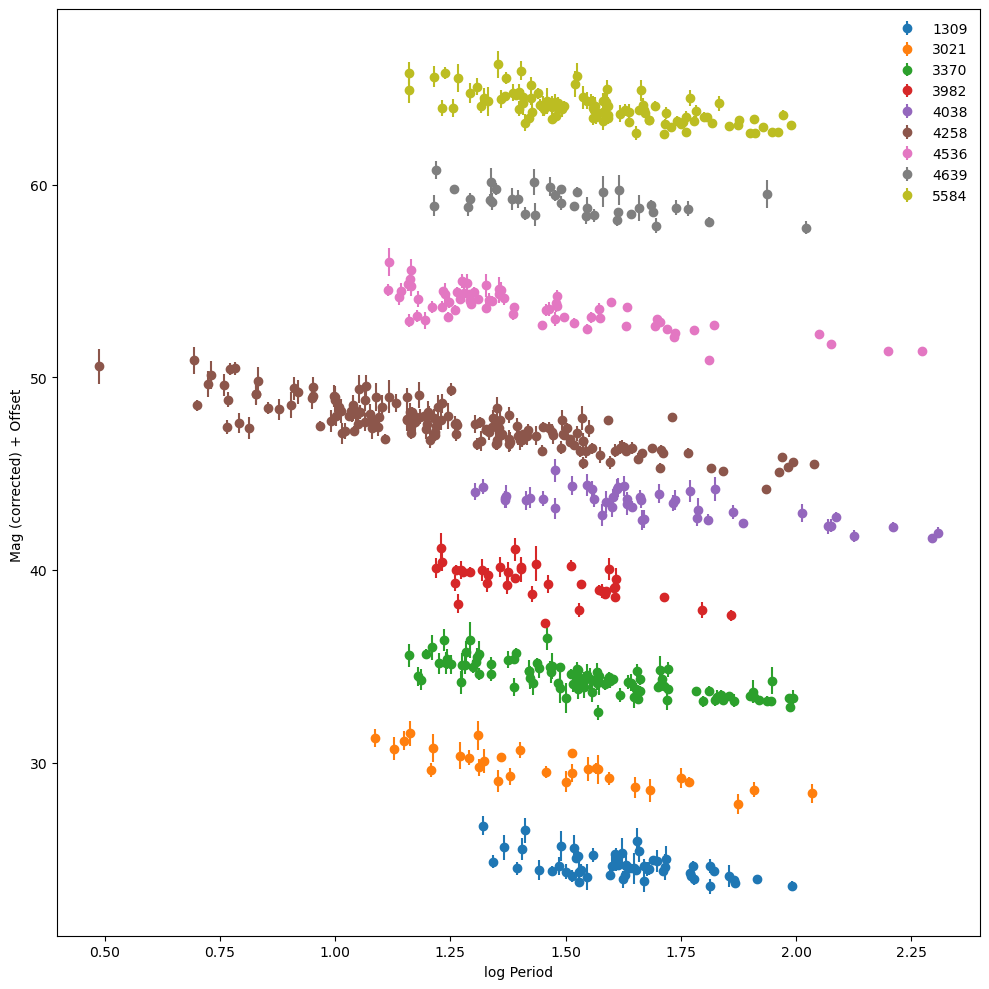

In [2]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs+(5*i), yerr=sigma_obs, linestyle='None', marker='o', label=ID) # offset so they arent overlapping
    
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
fig.tight_layout()

# Q1.

## This data was taken from [Riess et al., 2011](https://arxiv.org/abs/1103.2976)

## The global model for the magnitudes of these Cepheids is given in Equation 1. You may ignore the effect of metalicity

## Some parameters (such as distance modulus) are specific to each galaxy.

## Others are common to all galaxies. 

## Assuming Gaussian magnitude errors and no period error (and you may ignore metallicity entirely), but that Cepheids scatter off the period-luminosity relation because of some Gaussian intrinsic dispersion $\sigma_{\text{int}}$, write down your expression for the likelihood being careful to use the same indices that Riess et. al used.


### A1

The magnitude of the $j$th Cepheid in the $i$th host, is given by equation 1. When ignoring metalicity, the relation is:

$M(\mu_{0,i} - \mu_{0, 4258}, \log P_{i,j}, b_W, zp_{4158}) = M_{i,j} = (\mu_{0,i} - \mu_{0, 4258}) + zp_{4158} + b_W \log P_{i,j}$

- $\mu_{0,i} - \mu_{0, 4258}$ is the intercept and $b_W$ is the slope 

    - $\mu_{0,i}$ is the distance modulus of the host - this will be the same for all $j$ Cepheids, where $\mu_{0, 4258}$ is just for NGC 4258

    - $zp_{4258}$ is the intercept for NGC 4258, which is common for all hosts
    
    - $b_W$ is the slope of the period-luminosity relationship, which is also common for all hosts

Given the instrinstic Gaussian scatter, the probability of measuring $m_{W,i,j}$ of the $j$th Cepheid in the $i$th host is:

### $p(m_{W,i,j} | H) = \frac{1}{\sqrt{2\pi \sigma_{\text{int}}}} \exp \bigg( \frac{(m_{W,i,j} - M_{i,j})^2}{2\sigma_{\text{int}}^2}\bigg)$

Then the log likelihood of measuring all of the $j$ Cepheids in host $i$ is as follows:

$\begin{align} 
\ln L_i &= \log(\frac{1}{\sqrt{2\pi \sigma_{\text{int}}}}) +  \log(\exp \bigg( \frac{(m_{W,i,j} - M_{i,j})^2}{2\sigma_{\text{int}}^2}\bigg)\\
    &= -\frac{1}{2} \log(2\pi \sigma_{\text{int}}) + \frac{1}{2}\displaystyle \sum_j \frac{(m_{W,i,j} - M_{i,j})^2}{\sigma_{\text{int}}^2}\\
\end{align}$

Then the total log likelihood for all the hosts is given by:

$\begin{align} 
\ln L &= \displaystyle \prod_i \ln L_i \\
    &= \displaystyle \sum_i \ln L_i \\
\end{align}$

# Q2. 

## Given what you know for each of the parameters in this model, write down physically motivated (i.e. not just top hats on everything) priors, along with your explanation.

## Think particularly about the priors for distances to each galaxy.


# fix - explanation
    intercept is the difference in distance moduli - think about how a change in distance moduli relates to change in distance

$zp_{4258}$: $p(zp_{4258}) = U(24,28)$ given its distance modulus 

Intercepts $\mu_{0,i} - \mu_{0, 4258}$: $p(\mu_{0,i} - \mu_{0, 4258}) = U(0,5)$ since the model is with respect to NGC 4258, I've selected this range given the redshift provided. Given these redshifts, NGC $4258$ is the closest, and therefore all of the other hosts must have greater distance moduli.

- However, NGC $4258$  must have an intercept of 0 because it's intercept is $zp$ 

Slope $b_W$: $p(b_W) = U(-10, -1)$ - Since magnitudes are backwards, decreasing values mean brighter object and we know that generally that for brighter cepheids they will have longer periods. (explains negative) cannot be zero since the luminoisity is a product of the star's radius changing regularly.

# Q3. 

## Implement this likelihood and prior in python and sample the posterior distribution with emcee.

## Construct traceplots for each parameter, as well as corner plots for each pair of parameters.


## If your Markov Chains are reasonable, verify that your model fits are reasonable by reconstructing Fig. 7 of Riess et al. 2011

## Compare the intercept you find for the intercepts $\mu_{0,i} - \mu_{0, 4258}$ vs Table 3 of Riess et al. 2011

In [3]:
import scipy.stats as st
import emcee
import corner

In [9]:
for i, ID in enumerate(hosts):
    if ID =='4258':
        print(i)

5


In [11]:
# this theta will only have the mu for a single host
def model(theta, logP):
    zp, bW, mu = theta
    
    return bW*logP + zp + mu 

In [17]:
# first 9 theta values are intercepts for the 9 hosts
# 10th is zp
# 11th is slope
def log_prior(theta):
    zp = theta[5]
    bW = theta[-1] # last value
    
    p_b = st.uniform.pdf(bW, loc=-10, scale=9) # -10 to -1
    p_zp = st.uniform.pdf(zp, loc=20, scale=30) # again change when fixed
    p_mus = np.prod(np.array([st.uniform.pdf(theta[i], loc=0, scale=5) if i != 5 else 1 for i in range(len(hosts))]))
    
    # p_mus = 1
    # for i, ID in enumerate(hosts):
    #     mu = theta[i]
    #     if ID == '4258':
    #         if mu == 0: # mu for 4258 must be zero
    #             p_mus *= 1
    #         else:
    #             p_mus *= 0
    #     else: # all others follow the prior above
    #         p_mus *= st.uniform.pdf(mu, loc=-5, scale=10) # -5 to 5
   
    # take log of the products
    return np.log(p_b*p_zp*p_mus)

In [18]:
def log_likelihood(theta):
    # slope and zp are same for all hosts
    zp = theta[5]
    bW = theta[-1] # last item
    
    logL = [] # list of samples for each host
    for i, ID in enumerate(hosts):
        ceph.select(ID)
        mobs = np.array(ceph.mobs)
        logP = np.array(ceph.logP)
        sigma = np.array(ceph.sigma)
        
        # computing the chi-squared
            # prior will ensure mu 4258 is zero
        if i == 5:
            t = [zp, bW, 0]
        else:
            t = [zp, bW, theta[i]]
        diff = mobs - model(t, logP)
        logL.append(-(0.5)*np.sum(2*np.pi*sigma**2) - (0.5)*np.sum((diff/sigma)**2))
    
    # can sum logL instead of multiply them together
    return np.array(logL).sum()

In [19]:
def log_posterior(theta):
    lnL = log_likelihood(theta)
    lnpri = log_prior(theta)
    
    return lnL + lnpri

In [20]:
nwalkers = 25
ndim = 2+8 # slope, zp for 4258 + intercepts for other 8 hosts
nburn = 1000
nsteps = 5000
sigmas = np.ones(ndim)

# first 9 theta values are intercepts for the 9 hosts
# last is slope
guess = [1]*9 + [-2]
guess[5] = 27 # update zp

#samples = [] # list of samples for each host
#for i, ID in enumerate(hosts):
    #ceph.select(ID)
    #mobs = np.array(ceph.mobs)
    #logP = np.array(ceph.logP)
    #sigma = np.array(ceph.sigma)
    
    #args = (logP, mobs, sigma) - unneeded bc log posterior will figure it all out
    #kwargs = {'logP': logP, 'mobs': mobs, 'sigma':sigma}

p0 = np.array(guess) + 0.1*sigmas*np.random.randn(nwalkers, ndim) # ensures no duplicate values
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
state = sampler.run_mcmc(p0, nburn)
sampler.reset()
_ = sampler.run_mcmc(state, nsteps, progress=True); # suppress! its ugly
samples = sampler.get_chain(flat=True)
#samples.append(s) 

C:\Users\Haille Perkins\AppData\Local\Temp\ipykernel_872\1443319728.py:24: RuntimeWarning: divide by zero encountered in log
  return np.log(p_b*p_zp*p_mus)
100%|██████████| 5000/5000 [06:54<00:00, 12.07it/s]


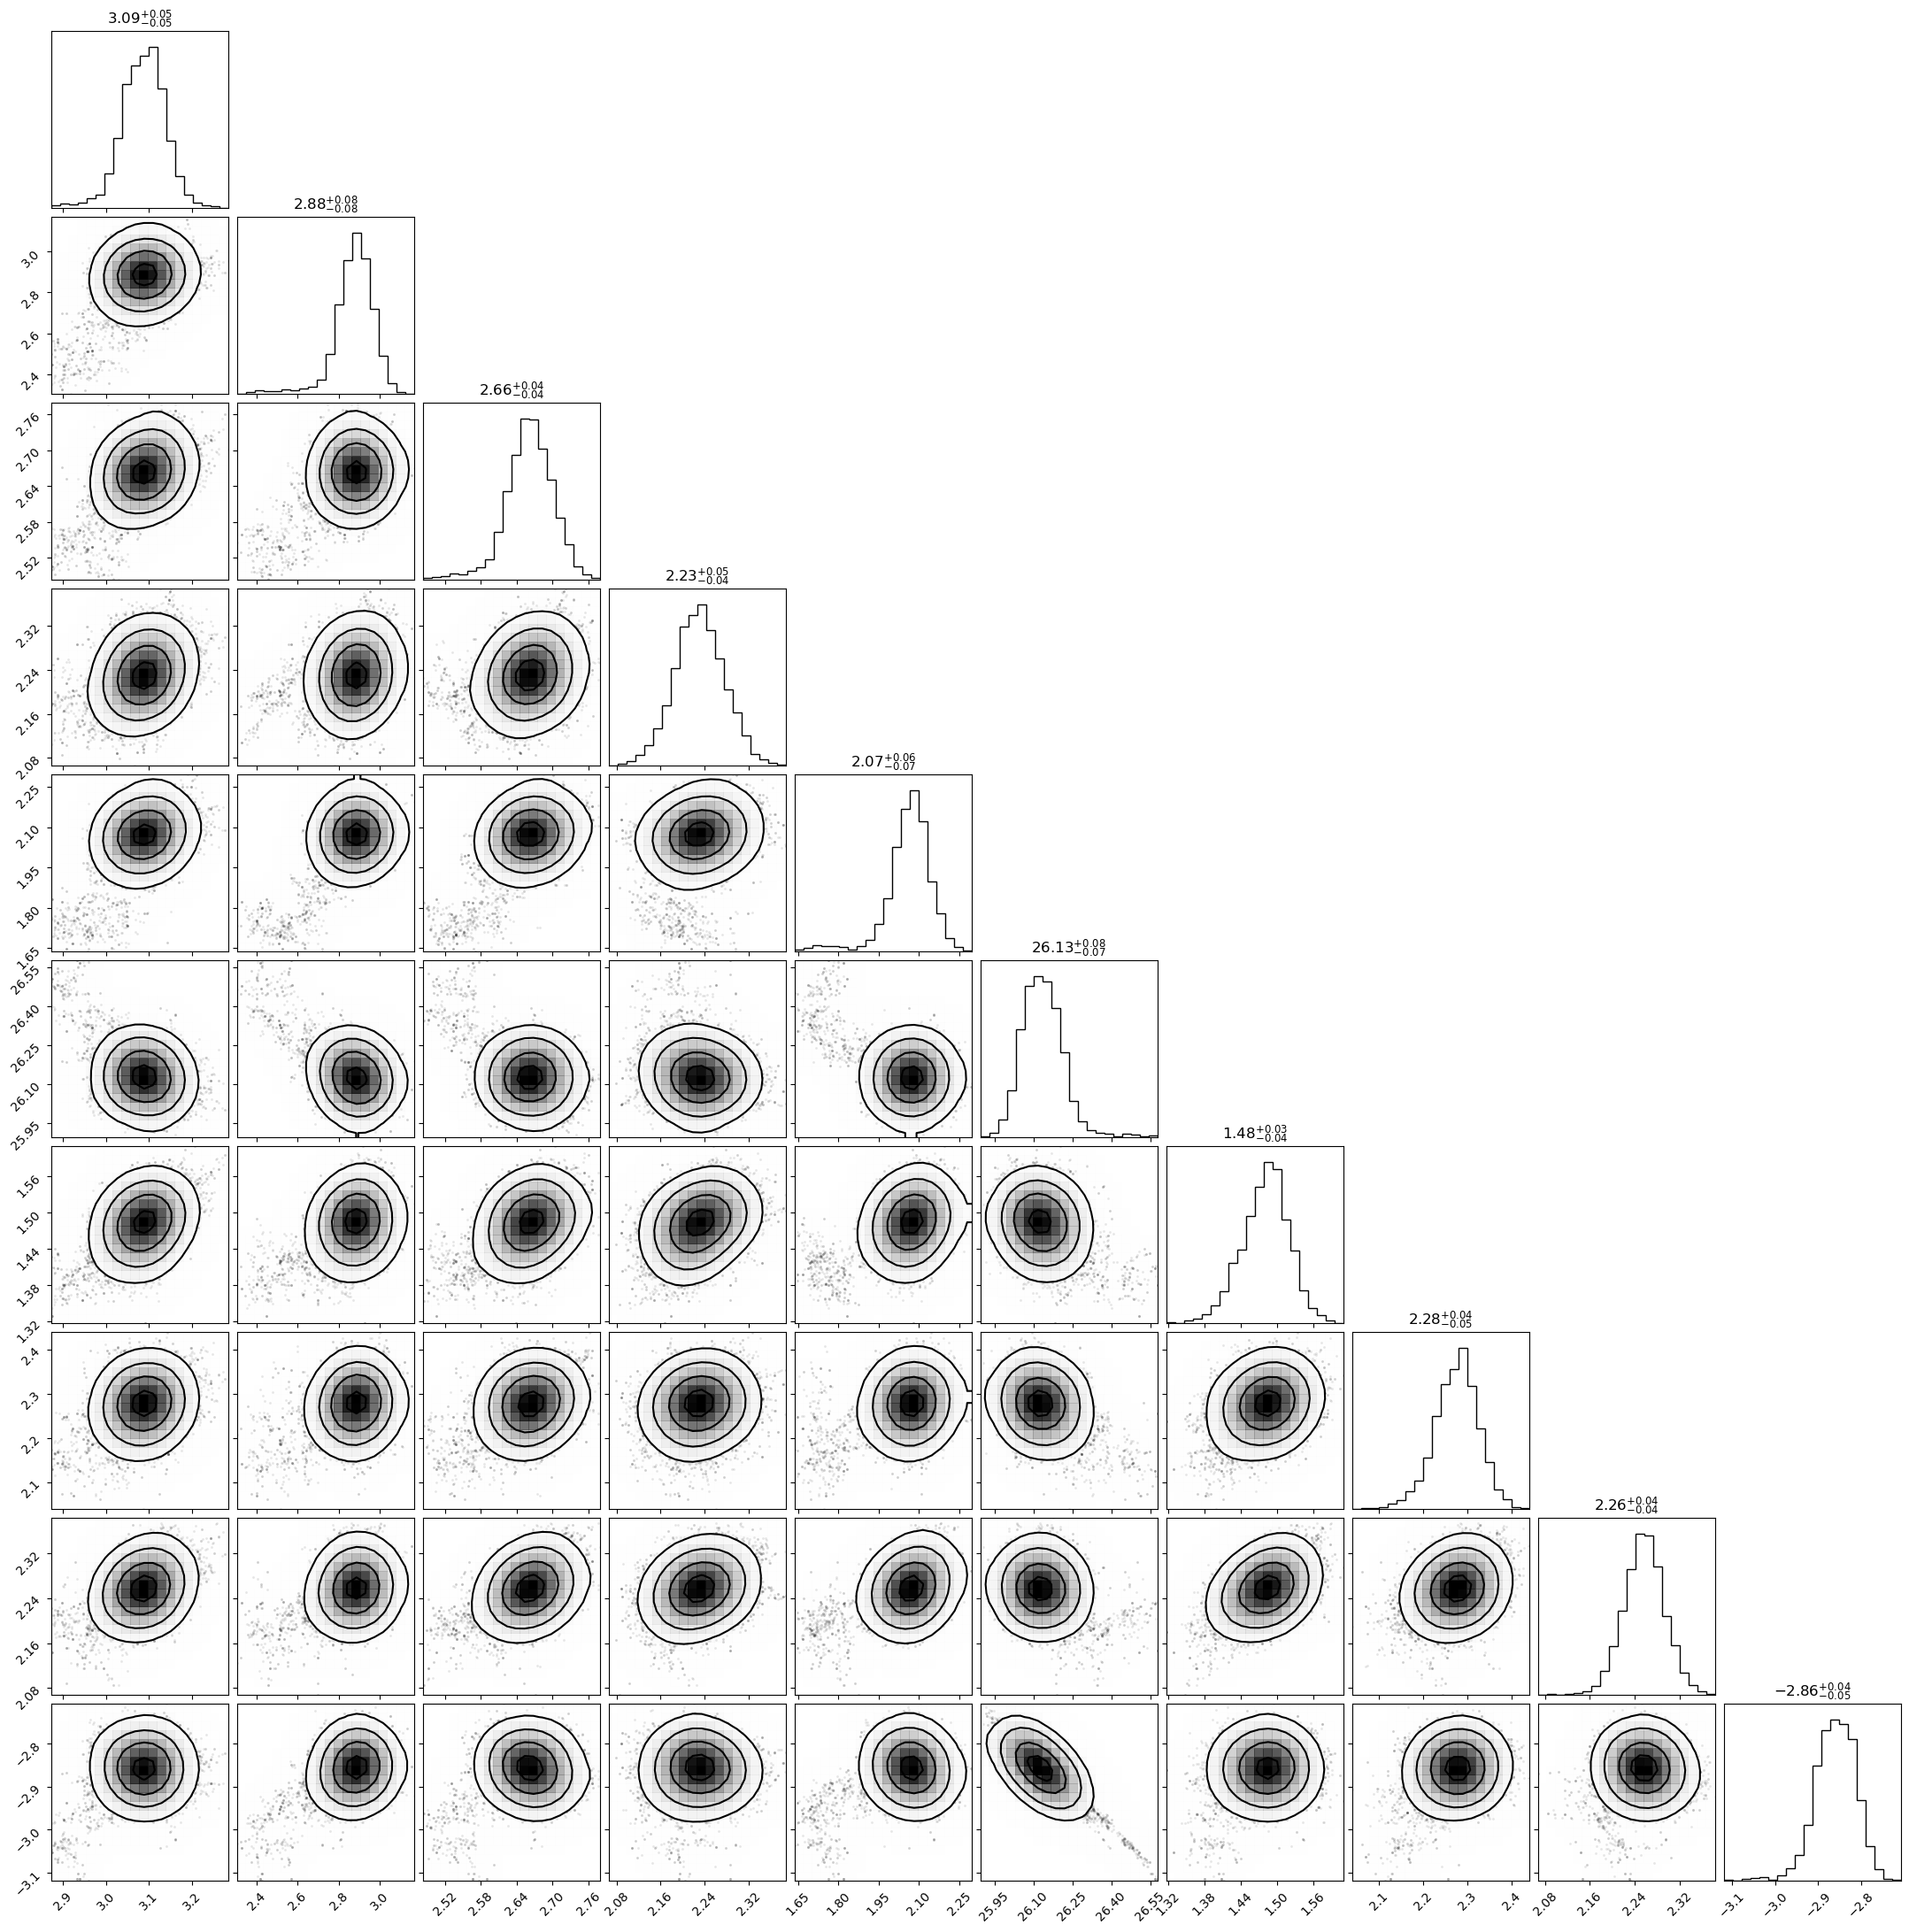

In [21]:
fig = corner.corner(samples[1000::10,:], plot_countours=True, show_titles=True, smooth=2)

#### Checking validity of chains

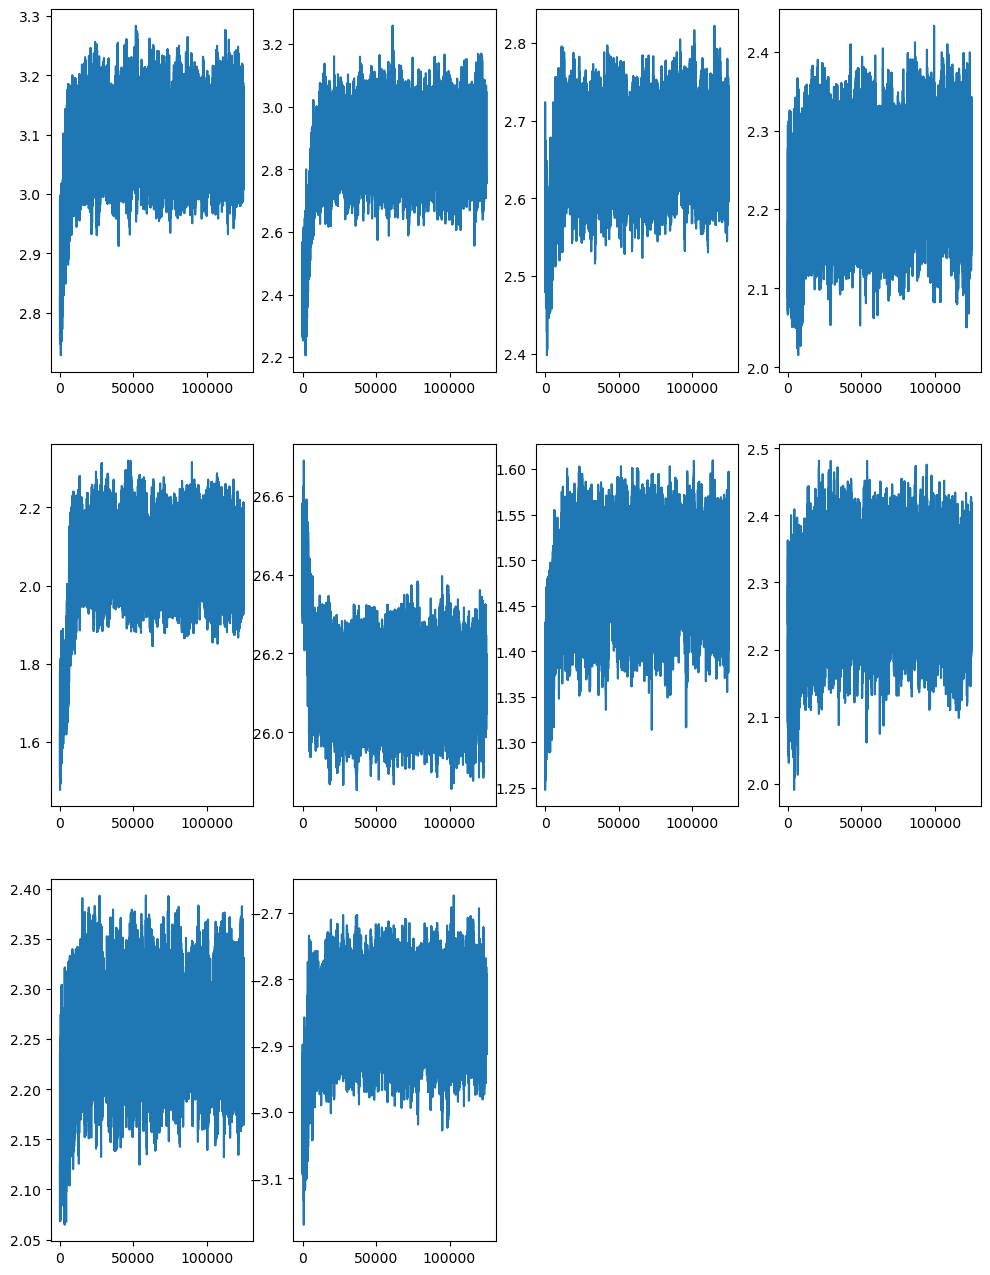

In [22]:
fig = plt.figure(figsize=(12, 16))
#labels = [r'$b_W$', r'$\mu_{int}$']
for i in range(ndim):
    ax = fig.add_subplot(3, 4, i+1)
    #ax.set_title("n"+ hosts[j])
    #ax.set_ylabel(labels[i])
    ax.plot(samples[:,i])
        #if i == 0:
        #    ax.set_ylim(-10, 0)
        #else:
        #    ax.set_ylim(-3, 5)

The chains seems stationary! So now, I'll take the median of the values to be my parameters.

#### Figure 7 recreation

In [23]:
params = np.percentile(samples, 50, axis=0)
params

array([ 3.09255801,  2.879748  ,  2.66203725,  2.22972954,  2.06941799,
       26.1246328 ,  1.48234416,  2.28351643,  2.25920836, -2.85506347])

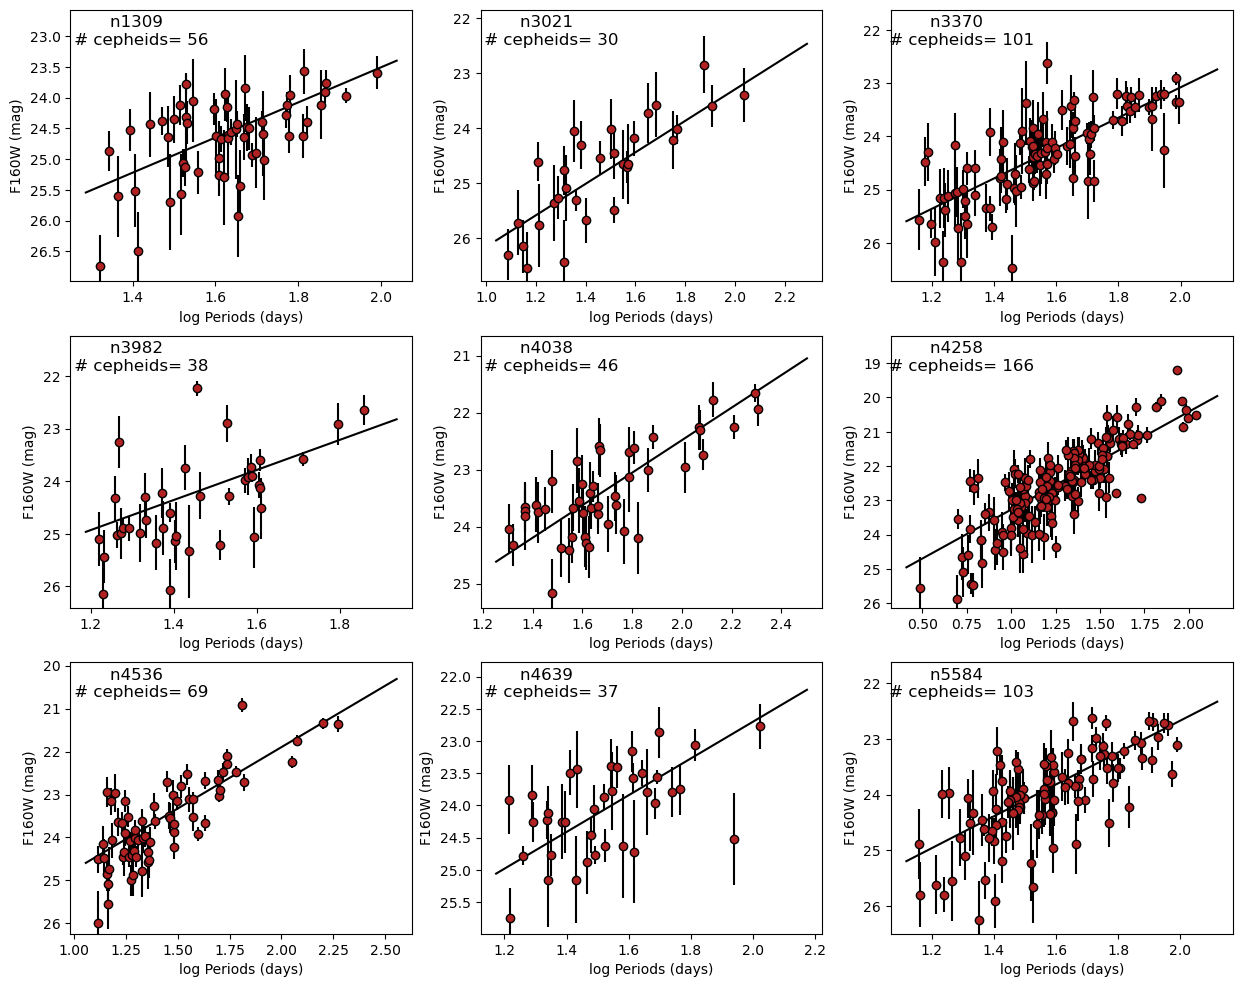

In [28]:
fig = plt.figure(figsize=(15, 12))
zp = params[5]
bW = params[-1]
for i, ID in enumerate(hosts):
    ax = fig.add_subplot(3,3,i+1)
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs, yerr=sigma_obs, 
                linestyle='None', marker='o', 
                ecolor='black', color='firebrick', markeredgecolor='black',
                label=ID)
    
    pmin, pmax = ax.get_xlim()
    parr = np.arange(pmin, pmax+0.25, 0.25)
    if i == 5:
        t = [zp, bW, 0]
    else:
        t = [zp, bW, params[i]]
    ax.plot(parr, model(t, parr), color='black')
    ax.set_ylim(mobs.min()-1, mobs.max()+0.25) # make room for title
    ax.invert_yaxis()
    title = f"n%s \n # cepheids= %d" % (ID, len(mobs)) 
    ax.set_title(title, x=0.2, y=1.0, pad=-25)
    ax.set_xlabel("log Periods (days)")
    ax.set_ylabel("F160W (mag)")

#### Comparing to Table 3:

In [29]:
intercepts = params[:-1] # all but the last 2
intercepts

array([ 3.09255801,  2.879748  ,  2.66203725,  2.22972954,  2.06941799,
       26.1246328 ,  1.48234416,  2.28351643,  2.25920836])

In [ ]:
params[-2]

$\begin{array}{c|c}
\text{NGC} & \text{MCMC} & \text{Table 3} \\
\hline
1309 & 3.093 &  3.276\\
3021 & 2.880 & 3.138 \\
3370 & 2.662 & 2.835 \\
3982 & 2.230 & 2.475 \\
4038 & 2.070 & 2.396 \\
4258 & - & - \\
4536 & 1.482 & 1.567 \\
4639 & 2.284 & 2.383 \\
5584 & 2.259 & 2.461 \\
\end{array}$

Not exact matches, but my values are all within $\pm 0.3$.

# Q4.

## Riess et al. do a *simultaneous* fit to the Cepheids and SNe data (Table 3 of their paper). 

## I'm slightly less cruel, so you can take your intercepts $\mu_{0,i} - \mu_{0, 4258}$ and the re-express equation 4 using a substitution of equation 3.

## Write that expression down.

Let $\mu_{int} = \mu_{0,i} - \mu_{0,4258}$. These are the intercepts determined above.

Equation 3: $m^0_{v,i} = (\mu_{0,i} - \mu_{0,4258}) + m^0_{v,4258} = \mu_{int} + m^0_{v,4258}$

Equation 4: $\log H_0 = \large \frac{(m^0_{v,4258} - \mu_{0,4258}) + 5a_v + 25}{5} $

Then using equation 3: $ m^0_{v,4258} = m^0_{v,i}- \mu_{int}$

Substituting into Equation 4:
$\begin{align}
\log H_0 &= \large \frac{(m^0_{v,4258} - \mu_{0,4258}) + 5a_v + 25}{5} \\
         &= \large \frac{(m^0_{v,i}- \mu_{int} - \mu_{0,4258}) + 5a_v + 25}{5} \\
         &= \large \frac{(m^0_{v,i} + 5a_v) - \mu_{int} - \mu_{0,4258}  + 25}{5} \\
\end{align}$

# Q5

## Using the supernova data in Table 3 (enter it into whatever data structure you deem best) and the distance modulus to NGC 4258 from [Humphreys et al., 2013 ](https://ui.adsabs.harvard.edu/abs/2013ApJ...775...13H/abstract) and using the simple sample statistics you learned in Week 1, estimate the Hubble constant.

In [30]:
hosts

array(['1309', '3021', '3370', '3982', '4038', '4258', '4536', '4639',
       '5584'], dtype='<U11')

In [43]:
m_5a = [16.768, 16.699, 16.545, 15.953, 15.901, 15.147, 16.040, 16.274]
mu_int = np.append(params[:5], params[6:-1]) # intercepts exclude zp and the slope
mu_4258 = params[5]

logH = [(m_5a[i] - mu_int[i] - zp + 25)/5 for i in range(len(m_5a))]
H = np.power(10, [(m_5a[i] - mu_int[i] - zp + 25)/5 for i in range(len(m_5a))])
#H = np.exp(logH)
# assume the central limit theorem
print(H)

[323.71426584 345.87871701 356.17709641 330.92344091 347.84826537
 322.11029621 336.02388875 378.47026832]


In [32]:
params[:5]

array([3.09255801, 2.879748  , 2.66203725, 2.22972954, 2.06941799])

In [33]:
params[6:-1]

array([1.48234416, 2.28351643, 2.25920836])